In [1]:
import numpy  as np
import pandas as pd
import math   as mt

from collections import Counter

import matplotlib.pyplot as plt 
from sklearn import linear_model, metrics
from plotly.offline import plot, iplot
from sklearn.model_selection import train_test_split

from plotly.offline import iplot
import plotly.graph_objs as go
import re
import base64
import pdb

import plotly.express as px
from sklearn import datasets
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



##### Data loading and preprocessing

In [2]:
cooking = pd.read_csv("./whats-cooking/sample_submission.csv")
cooking.head(4)
cooking.shape
cooking.head()

,id,cuisine
0,35203,italian
1,17600,italian
2,35200,italian
3,17602,italian
4,17605,italian


In [3]:
train = pd.read_json('./whats-cooking/train.json')
train.head(4)
train.shape
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
test = pd.read_json('./whats-cooking/test.json')
test.head(4)
test.shape

(9944, 2)

from graph we can see that top cuisines are Italian, mexican, southern_us...
there are 20 cuisines in data

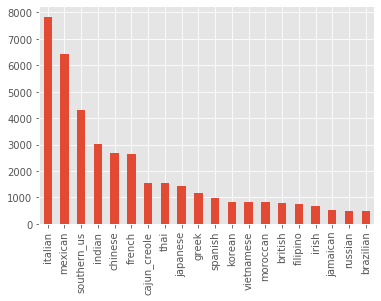

In [5]:
plt.style.use('ggplot')
train['cuisine'].value_counts().plot(kind='bar')

#### convert all letters to lowercase in ingredients

In [6]:
for i in range(0, 39774):
    train["ingredients"][i] = [x.lower() for x in train["ingredients"][i]]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



lets find outliers(like water=>Japanese) and remove them 

In [7]:
train['num_ingredients'] = train['ingredients'].apply(len)
train = train[train['num_ingredients'] > 1]
train.shape

(39752, 4)

In [8]:
train

,id,cuisine,ingredients,num_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20
...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",12
39770,11462,italian,"[kraft zesty italian dressing, purple onion, b...",7
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...",12
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...",21


In [9]:
id_ = []
train["ingredients"]= [i for i in train.ingredients if(len(i) >=2)]
train.shape

(39752, 4)

remove words that consist less than 2 charaters

In [10]:
ingredients_dict = dict()
for item in train.ingredients:
    for i in item:
        if i in ingredients_dict:
            ingredients_dict[i] += 1
        else:
            ingredients_dict[i] = 0
train.ingredients = [[j for j in group if ingredients_dict[j] != 0 ] for group  in train.ingredients ]

In [11]:
test['num_ingredients'] = test['ingredients'].apply(len)
test = test[test['num_ingredients'] > 1]
test.shape

(9936, 3)

In [12]:
test["ingredients"]= [i for i in test.ingredients if(len(i) >=2)]
test.shape

(9936, 3)

In [13]:
ingredients_dict = dict()
for item in test.ingredients:
    for i in item:
        if i in ingredients_dict:
            ingredients_dict[i] += 1
        else:
            ingredients_dict[i] = 0
test.ingredients = [[j for j in group if ingredients_dict[j] != 0 ] for group  in test.ingredients ]

let's count most frequent ingredient for each cuisine

In [14]:
train

,id,cuisine,ingredients,num_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20
...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",12
39770,11462,italian,"[kraft zesty italian dressing, purple onion, b...",7
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...",12
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...",21


In [15]:
counters = {}
for cuisine in train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (train['cuisine'] == cuisine)
    for ingredients in train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [16]:
counters

{'greek': Counter({'romaine lettuce': 39,
          'black olives': 31,
          'grape tomatoes': 26,
          'garlic': 216,
          'pepper': 203,
          'purple onion': 186,
          'seasoning': 3,
          'garbanzo beans': 23,
          'feta cheese crumbles': 252,
          'ground pork': 4,
          'finely chopped fresh parsley': 8,
          'onions': 185,
          'salt': 572,
          'vinegar': 3,
          'caul fat': 1,
          'minced garlic': 68,
          'dried oregano': 267,
          'red wine vinegar': 99,
          'olive oil': 504,
          'boneless chop pork': 1,
          'lemon juice': 183,
          'orange': 12,
          'anise': 5,
          'cinnamon sticks': 31,
          'unflavored gelatin': 2,
          'zinfandel': 2,
          'orange blossom honey': 3,
          'sugar': 77,
          'lemon': 129,
          'calimyrna figs': 1,
          'clove': 14,
          'honey': 67,
          'whipping cream': 2,
          'plain whole-mil

In [17]:
top_ingredients = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
                               index=[cuisine for cuisine in counters],
                               columns=['top{}'.format(i) for i in range(1, 11)])
top_ingredients 

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


The most popular ingredients that are present across many
dishes, which we suspect may have lower predictive power in
distinguishing cuisines, are as follows:

In [18]:
import operator
counters = {}
for ingredients in train['ingredients']:
    for ing in ingredients:
        if ing in counters:
            counters[ing] += 1
        else:
            counters[ing] = 1
sorted_ingredients = sorted(counters.items(), key=operator.itemgetter(1), reverse = True)
sorted_ingredients

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7456),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4846),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4384),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113),
 ('green onions', 3078),
 ('tomatoes', 3058),
 ('large eggs', 2948),
 ('carrots', 2814),
 ('unsalted butter', 2779),
 ('ground cumin', 2747),
 ('extra-virgin olive oil', 2747),
 ('black pepper', 2627),
 ('milk', 2263),
 ('chili powder', 2036),
 ('oil', 1970),
 ('red bell pepper', 1939),
 ('purple onion', 1896),
 ('scallions', 1891),
 ('grated parmesan cheese', 1886),
 ('sesame oil', 1773),
 ('corn starch', 1757),
 ('ginger', 1755),
 ('baking powder', 1738),
 ('jalapeno chilies', 1730),
 ('dried oregano', 1707),
 ('chopped cilantro fresh', 1698),
 ('fresh lemon juice', 1679),
 ('diced tomatoes', 1624),
 ('fresh parsley', 1604),
 ('minced garlic', 1583),
 ('chicken

let's see which ingredients are highly specific to some cuisine

In [19]:
# Function to convert list to string 
def listToString(s):  
    str_ = ", "  
    return (str_.join(s)) 

In [20]:
train["ingredients"] = train["ingredients"].apply(listToString)
train["ingredients"]

0        romaine lettuce, black olives, grape tomatoes,...
1        plain flour, ground pepper, salt, tomatoes, gr...
2        eggs, pepper, salt, mayonaise, cooking oil, gr...
3                        water, vegetable oil, wheat, salt
4        black pepper, shallots, cornflour, cayenne pep...
                               ...                        
39769    light brown sugar, granulated sugar, butter, w...
39770    kraft zesty italian dressing, purple onion, br...
39771    eggs, citrus fruit, raisins, sourdough starter...
39772    boneless chicken skinless thigh, minced garlic...
39773    green chile, jalapeno chilies, onions, ground ...
Name: ingredients, Length: 39752, dtype: object

In [21]:
top_unique_ingredients = np.unique(top_ingredients.values.ravel())
top_unique_ingredients

array(['all-purpose flour', 'avocado', 'baking powder', 'baking soda',
       'black pepper', 'butter', 'buttermilk', 'cachaca',
       'cajun seasoning', 'carrots', 'cayenne pepper', 'chili powder',
       'coconut milk', 'corn starch', 'corn tortillas', 'cumin seed',
       'dried oregano', 'dried thyme', 'eggs', 'extra-virgin olive oil',
       'feta cheese crumbles', 'fish sauce', 'fresh lemon juice',
       'fresh lime juice', 'garam masala', 'garlic', 'garlic cloves',
       'ginger', 'grated parmesan cheese', 'green bell pepper',
       'green onions', 'ground allspice', 'ground black pepper',
       'ground cinnamon', 'ground cumin', 'ground ginger',
       'ground turmeric', 'jalapeno chilies', 'large eggs', 'lime',
       'milk', 'mirin', 'oil', 'olive oil', 'onions', 'paprika', 'pepper',
       'potatoes', 'red bell pepper', 'rice vinegar', 'sake', 'salt',
       'scallions', 'sesame oil', 'sesame seeds', 'shallots',
       'sour cream', 'soy sauce', 'sugar', 'tomatoes', 'un

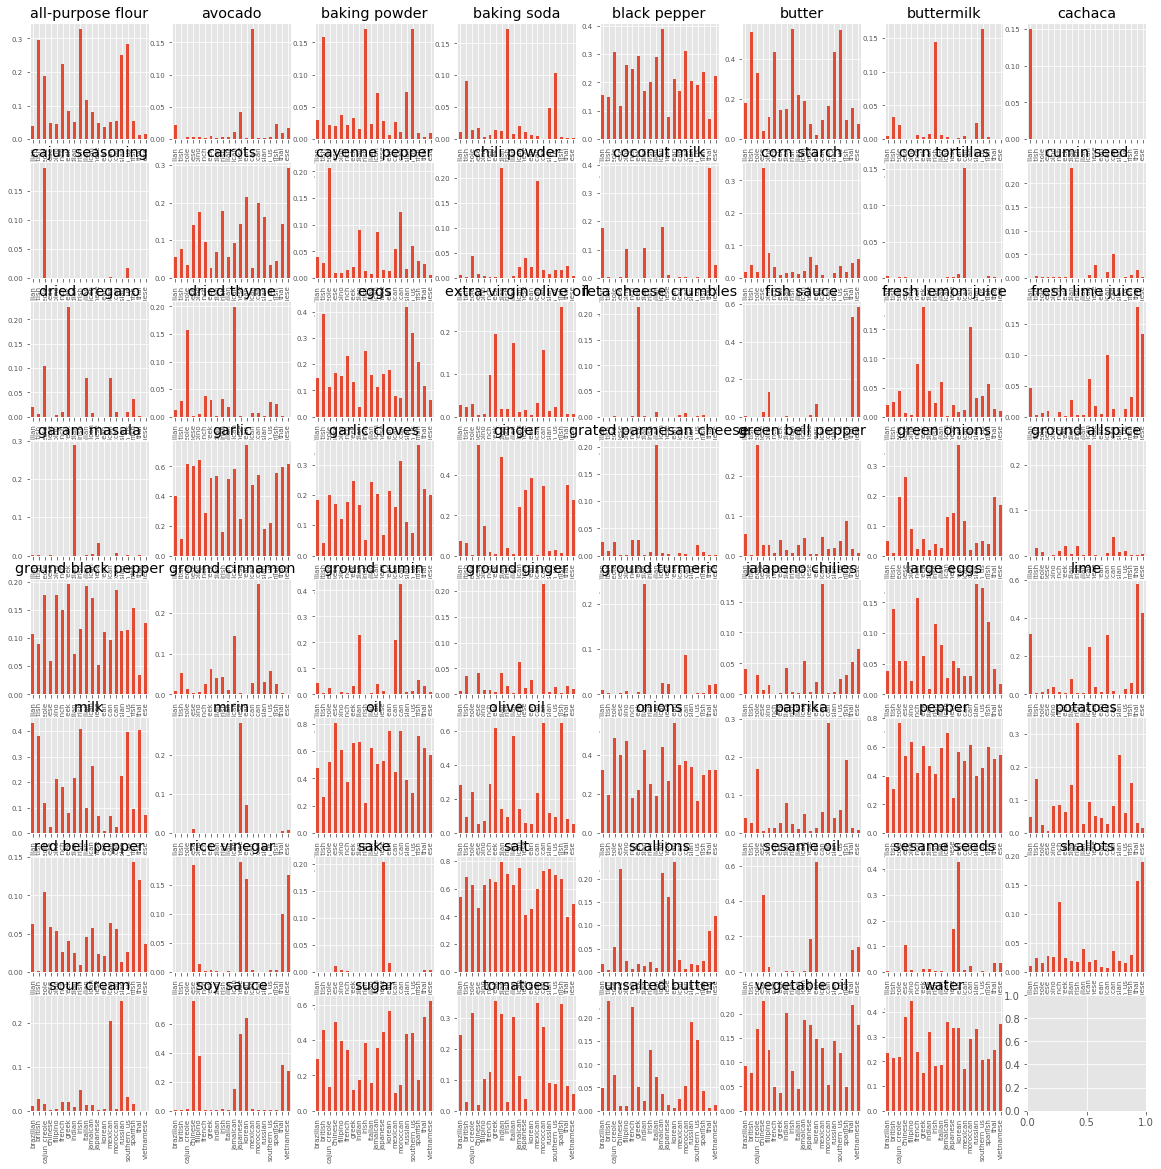

In [22]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(top_unique_ingredients, range(64)):
    indices = train['ingredients'].str.contains(ingredient)
    relative_freq = (train[indices]['cuisine'].value_counts() / train['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

training logistic regression

let's encode data in matrix 

In [23]:
def clean_string(ingredient_text):
    return "".join([char for char in ingredient_text.lower() if char.isalnum() or char.isspace()])

In [24]:
train['better_ingredients'] = train['ingredients'].map(clean_string)

In [25]:
cv = CountVectorizer()
X = cv.fit_transform(train['better_ingredients'].values)
X

<39752x2439 sparse matrix of type '<class 'numpy.int64'>'
	with 747006 stored elements in Compressed Sparse Row format>

In [26]:
X.shape

(39752, 2439)

In [27]:
enc = LabelEncoder()
y = enc.fit_transform(train.cuisine)

In [28]:
y

array([ 6, 16,  4, ...,  8,  3, 13])

In [29]:
train.cuisine

0              greek
1        southern_us
2           filipino
3             indian
4             indian
            ...     
39769          irish
39770        italian
39771          irish
39772        chinese
39773        mexican
Name: cuisine, Length: 39752, dtype: object

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
logistic.score(X_test, y_test)

0.7903408376304867

In [33]:
y_pred = logistic.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.60      0.68        95
           1       0.58      0.39      0.47       168
           2       0.74      0.71      0.72       290
           3       0.82      0.84      0.83       564
           4       0.62      0.62      0.62       117
           5       0.62      0.62      0.62       522
           6       0.79      0.76      0.78       228
           7       0.86      0.90      0.88       621
           8       0.67      0.54      0.60       120
           9       0.81      0.91      0.86      1562
          10       0.88      0.70      0.78       118
          11       0.89      0.67      0.76       296
          12       0.79      0.75      0.77       171
          13       0.90      0.93      0.92      1240
          14       0.85      0.74      0.80       172
          15       0.60      0.37      0.46        99
          16       0.71      0.80      0.75       888
          17       0.65    

In [34]:
X_test.shape

(7951, 2439)

In [35]:
sum(y_test == y_pred)

6284

In [36]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem
import numpy as np
def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: ", np.mean(scores))

In [37]:
logistic = LogisticRegression()
evaluate_cross_validation(logistic, X, y, 5)

[0.78518425 0.78354924 0.79069182 0.78578616 0.78603774]
Mean score:  0.7862498431825751


In [38]:
evaluate_cross_validation(logistic, X, y, 10)

[0.78470825 0.78873239 0.78490566 0.7808805  0.79245283 0.79371069
 0.78415094 0.78918239 0.78188679 0.79018868]
Mean score:  0.7870799134429217


In [39]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [40]:
tree.score(X_test, y_test)

0.6288517167651868

In [41]:
from sklearn.neighbors import KNeighborsClassifier
neighbor=KNeighborsClassifier()
neighbor.fit(X_train,y_train)
neighbor.score(X_test, y_test)

0.639919506980254

### lets try to predict ingredients from cuisines

In [42]:
columns = []
for col in top_ingredients.T.columns:
    str_ = ""
    ing = []
    for ingredient in top_ingredients.T[col]:
        str_ = str_ + ingredient + ", "
    str_ = str_[:-2]
    ing.append(str_)
    columns.append(ing)
columns

col1 = top_ingredients.T.columns
col1

Index(['greek', 'southern_us', 'filipino', 'indian', 'jamaican', 'spanish',
       'italian', 'mexican', 'chinese', 'british', 'thai', 'vietnamese',
       'cajun_creole', 'brazilian', 'french', 'japanese', 'irish', 'korean',
       'moroccan', 'russian'],
      dtype='object')

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
model = MultinomialNB()
param_grid = {'alpha': [0, 0.01, 0.05,0.1,0.5,1,2,5,10]}
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=4, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=4,
             param_grid={'alpha': [0, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [44]:
predicted = grid_search.predict(X_test)

In [45]:
sum(predicted == y_test)

5746

In [46]:
len(y_test)

7951

In [47]:
accuracy_score(y_test, predicted)

0.7226763929065526

In [55]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
clf = make_pipeline(StandardScaler(with_mean=False),
                    LinearSVC(random_state=0, tol=1e-5, max_iter = 15000))
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [56]:
accuracy_score(y_test, predicted)

0.7458181360835116